In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from ukf  import *
from utils import *
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'
v_nums = [i for i in range(100)]
routes = [0]

ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
print(len(ev_dataset))

23595


In [3]:
model = ANN(activation='relu', layers=[3, 4, 8, 16, 8, 4, 1])

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
loss = torch.nn.functional.l1_loss

In [4]:
if os.path.isfile('initial_model.pt'):
    print('Initial model exists')
    
else:
    v_nums = [i for i in range(100)]
    routes = [0]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=256, shuffle=True)
    epochs = 40

    loss_history = [[], []]

    start_time = time.time()
    for _ in range(epochs):
        model.train()
        train_loss = 0
        for inp, tar in train_loader:
            optimizer.zero_grad()
            output = model(inp)
            l = loss(output, tar)
            l.backward()
            optimizer.step()
            train_loss += l.item()
        train_loss /= len(train_loader)

        loss_history[0].append(_)
        loss_history[1].append(train_loss)

        if (_ % 5 == 0) or (_+1 == epochs):
            print(f'epoch num {_} loss : {train_loss}')

    print(f'time : {time.time() - start_time : .2f}')

    plt.plot(loss_history[0], loss_history[1], label='train_loss')
    plt.legend()
    plt.xlabel('Epoch number')
    plt.ylabel('MAE loss')
    plt.show()

    torch.save({
        'epoch' : epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    }, 'initial_model.pt')

epoch num 0 loss : 0.6216181284317406
epoch num 5 loss : 0.037526904174717525
epoch num 10 loss : 0.030043357873075112
epoch num 15 loss : 0.025234429075592948
epoch num 20 loss : 0.021917281121576346
epoch num 25 loss : 0.017734417842040138
epoch num 30 loss : 0.014162762120606439
epoch num 35 loss : 0.011065569215564317
epoch num 39 loss : 0.009862996682885193
time :  616.98


In [7]:
checkpoint = torch.load('initial_model.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [8]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
epoch = checkpoint['epoch']

In [10]:
v0_model = deepcopy(model)
v0_optimizer = torch.optim.Adam(params=v0_model.parameters(), lr = 0.001)

v_nums = [0]

loss_hist = [[], [], [], []]

for route_num in range(1, 100):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=128, shuffle=True)

    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)

    if l_1 > 0.05:
        print(f'model updated at route number {route_num}')
        loss_hist[3].append(route_num)
        for i in range(epochs):
            l_1 = 0
            for inp, tar in train_loader:
                v0_optimizer.zero_grad()
                output = v0_model(inp)
                v0_loss = loss(output, tar)
                v0_loss.backward()
                v0_optimizer.step()
                l_1 += v0_loss.item()
            l_1 /= len(train_loader)


    loss_hist[0].append(route_num)
    loss_hist[1].append(l_0)
    loss_hist[2].append(l_1)

print(f'model updated {len(loss_hist[3])} times after initial model')

model updated at route number 17
model updated at route number 31
model updated at route number 38
model updated at route number 44
model updated at route number 52
model updated at route number 61
model updated at route number 67
model updated at route number 68
model updated at route number 72
model updated at route number 77
model updated at route number 80
model updated at route number 85
model updated at route number 90
model updated at route number 94
model updated at route number 95
model updated at route number 97
model updated 16 times after initial model


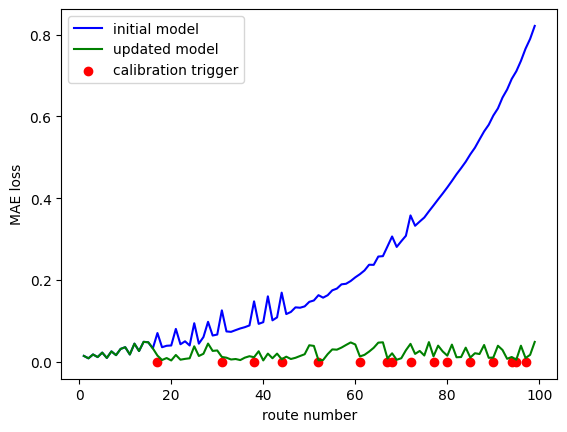

In [11]:
plt.plot(loss_hist[0], loss_hist[1], label = 'initial model', c='b')
plt.plot(loss_hist[0], loss_hist[2], label = 'updated model', c='g')
plt.scatter(loss_hist[3], [0 for _ in loss_hist[3]], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
plt.show()